In [2]:
import numpy as np, pandas as pd, sqlite3
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets._samples_generator import make_blobs
from sklearn import metrics

### Data

In [62]:
df_in = pd.read_csv('data.csv', index_col=0)
df_in.head()

,symbol,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,575,-0.001137,0.008527,-0.005808,-0.003630,0.010863,0.005933,-0.002473,0.002579,-0.001755,...,-0.012214,-0.003507,0.003961,0.001404,-0.006647,0.001274,0.009193,-0.002167,-0.006118,0.001938
1,537,0.010103,-0.001521,-0.001524,0.003354,0.005616,0.001217,-0.001517,0.002732,-0.000304,...,-0.019349,-0.005060,-0.004344,0.002893,-0.001817,-0.001446,0.001454,-0.003252,0.010388,0.011544
2,649,0.010156,0.003907,-0.006261,-0.002778,0.005568,0.001522,-0.002581,0.001057,0.000497,...,-0.000754,0.001300,0.003704,0.007972,0.000918,-0.009861,-0.009649,-0.009703,0.000843,0.015026
3,1,0.009744,0.002821,0.005121,0.005097,0.005989,0.002376,-0.000714,0.001137,-0.003807,...,-0.004954,-0.003002,0.000000,0.003549,0.001353,0.002059,0.003372,-0.003671,-0.005664,0.000903
4,132,0.005622,0.000148,0.001327,0.002505,0.001913,0.000883,0.001291,0.002204,-0.001176,...,-0.000938,0.000469,0.001251,-0.002692,-0.002502,0.002817,0.001564,0.000000,0.000000,0.000000


### Scale values

In [64]:
from sklearn.preprocessing import StandardScaler
def scale(df, symbols):
    scale = StandardScaler()
    if 'symbol' in df.columns:
        df = df.iloc[:,1:]
    arr_scaled = scale.fit_transform(df)
    df_scaled = pd.DataFrame(arr_scaled)
    df_scaled.insert(loc=0, column='symbol', value=symbols) # Insert ticker column
    return(df_scaled)
df_scaled = scale(df_in, symbols=df_in.symbol)
df_scaled.head()

,symbol,0,1,2,3,4,5,6,7,8,...,323,324,325,326,327,328,329,330,331,332
0,575,-0.648018,0.950573,-1.278249,-0.424756,1.308712,1.029614,-0.784523,0.093321,-0.167799,...,-0.471970,0.235687,0.941589,-0.182861,-1.645517,0.180078,1.471469,0.088403,-0.909620,-0.210074
1,537,0.531791,-0.798194,-0.640297,0.310759,0.550993,0.012219,-0.576396,0.124944,0.120949,...,-1.251706,0.020983,-0.641875,0.123572,-0.620200,-0.499707,-0.017904,-0.131772,2.665136,1.640602
2,649,0.537435,0.146508,-1.345765,-0.335097,0.544121,0.077932,-0.808148,-0.222339,0.280198,...,0.780444,0.900275,0.892432,1.168409,-0.039459,-2.602787,-2.154642,-1.440953,0.597831,2.311504
3,1,0.494101,-0.042419,0.349378,0.494310,0.604832,0.262265,-0.401481,-0.205700,-0.575930,...,0.321438,0.305458,0.186302,0.258558,0.052871,0.376225,0.351244,-0.216853,-0.811402,-0.409514
4,132,0.061490,-0.507811,-0.215704,0.221325,0.016416,-0.059846,0.035204,0.015456,-0.052533,...,0.760336,0.785310,0.424777,-1.025505,-0.765566,0.565702,0.003303,0.528106,0.415330,-0.583472


### Produce features

In [96]:
from cesium import featurize as ft
times = []
log_return_values = []
for idx, row in df_scaled.iterrows():
    log_return_values.append(row.values)
    times.append(np.array([i for i in range(row.values.shape[0])]))

fs = ['amplitude',
                   'percent_beyond_1_std',
                   'max_slope',
                   'percent_close_to_median',
                   'weighted_average',
                   'maximum',
                   'minimum',
                   'median',
                   'skew']

df_features = ft.featurize_time_series(
                    times           = times,
                    values          = log_return_values,
                    errors          = None,
                    features_to_use = fs,
                    scheduler       = None)

# Remove multihead, scale and put 'back' headers
df_features = df_features.T.reset_index().drop(['channel'], axis=1).iloc[:,1:].T
df_features_scaled = scale(df_features, symbols=df_in.symbol)
df_features_scaled = df_features_scaled.rename(columns={0:fs[0], 1:fs[1], 2:fs[2], 
                    3:fs[3], 4:fs[4], 5:fs[5], 6:fs[6], 7:fs[7], 8:fs[8]}) 
df_features_scaled.head()

,symbol,amplitude,percent_beyond_1_std,max_slope,percent_close_to_median,weighted_average,maximum,minimum,median,skew
0,575,0.277272,-0.131852,0.280076,0.102933,0.184499,0.277578,0.011177,0.106045,0.184490
1,537,0.130170,-0.131852,0.131261,0.102933,0.086773,0.133263,0.310822,-0.353695,0.197726
2,649,0.558421,-0.131852,0.556645,0.102933,0.377458,0.558612,-0.021491,-1.513659,0.200395
3,1,-1.906503,9.422338,-1.898100,-10.966974,-1.860575,-1.898212,0.999970,0.619484,-8.685271
4,132,-1.398942,-0.131852,-1.405250,0.102933,-1.377705,-1.404828,-0.506257,0.575779,0.088966


### Apply GMM

In [181]:
X = np.array(df_features)
sils = []
bics = []
aics = []
components_range = range(2,30,1)
for cl in components_range:
    fit = GMM(n_components=cl, random_state=0, covariance_type='diag').fit(X)
    labels = fit.predict(X)
    sil = metrics.silhouette_score(X, labels, metric='euclidean')
    sils.append(sil)
    bics.append(fit.bic(X))
    aics.append(fit.aic(X))

Text(0.5, 1.0, 'Silhouhette score')

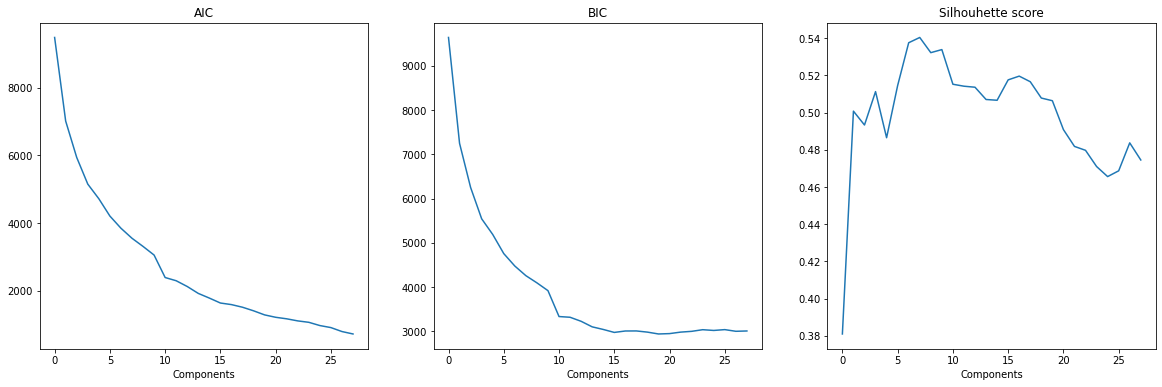

In [182]:
import matplotlib.pyplot as plt
x = components_range

# Create just a figure and only one subplot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
scores = ['AIC', 'BIC', 'Sihouette score']
ax1.plot(aics)
ax1.set_title('AIC')
ax1.set(xlabel='Components')
ax2.plot(bics)
ax2.set(xlabel='Components')
ax2.set_title('BIC')
ax3.plot(sils)
ax3.set(xlabel='Components')
ax3.set_title('Silhouhette score')